In [92]:
import scipy.io as sio
import sklearn.preprocessing as prep
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
!cp /content/drive/MyDrive/capstone/BNC-DGHL/Datasets/* ./Datasets

In [201]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


def mapStd(X,X_train,X_valid,X_test):
    preprocessor=prep.StandardScaler().fit(X)
    X = preprocessor.transform(X)
    X_train = preprocessor.transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(X_test)
    return X,X_train,X_valid,X_test


def mapMinmax(X,X_train,X_valid,X_test):
    preprocessor=prep.MinMaxScaler().fit(X)
    X = 2*preprocessor.transform(X)-1
    X_train = 2*preprocessor.transform(X_train)-1
    X_valid = 2*preprocessor.transform(X_valid)-1
    X_test = 2*preprocessor.transform(X_test)-1
    return X,X_train,X_valid,X_test


def mapMinmax2(X_train,X_valid,X_test):
    scaler_minmax = MinMaxScaler()
    X_train = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))
    X_valid = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))
    X_test = torch.tensor(scaler_minmax.fit_transform(X_train.reshape(-1, 90*90)))
    return X_train.reshape(-1, 1, 90, 90),X_valid.reshape(-1, 1, 90, 90),X_test.reshape(-1, 1, 90, 90)



def load_data(fold):
    data = sio.loadmat('./Datasets/ALLASD{}_NETFC_SG_Pear.mat'.format(fold+1))
    X = data['net']
    X_train = data['net_train']
    X_valid = data['net_valid']
    X_test = data['net_test']

    Idx = [2, 3, 4, 5, 6, 7, 8, 9]  # 3:Age 4:Sex 5:Handedness 6:FIQ 7:VIQ 8:PIQ 9:EYE Status
    Y = data['phenotype'][:, Idx]
    Y_train = data['phenotype_train'][:, Idx]
    Y_valid = data['phenotype_valid'][:, Idx]
    Y_test = data['phenotype_test'][:, Idx]
    col_idx = [1, 4, 5, 6]  # 3:Age 6:FIQ 7:VIQ 8:PIQ
    Y[:, col_idx], Y_train[:, col_idx], \
    Y_valid[:, col_idx], Y_test[:, col_idx] = mapStd(Y[:, col_idx],
                                                     Y_train[:, col_idx],
                                                     Y_valid[:, col_idx],
                                                     Y_test[:, col_idx])
    col_idx = [2, 3, 7]
    Y[:, col_idx], Y_train[:, col_idx], \
    Y_valid[:, col_idx], Y_test[:, col_idx] = mapMinmax(Y[:, col_idx],
                                                        Y_train[:, col_idx],
                                                        Y_valid[:, col_idx],
                                                        Y_test[:, col_idx])


    Y_train2 = data['phenotype_train'][:, 2]
    Y_valid2 = data['phenotype_valid'][:, 2]
    Y_test2 = data['phenotype_test'][:, 2]

    ln = nn.LayerNorm(normalized_shape=[90, 90], elementwise_affine=False)
    X_train = ln(torch.tensor(X_train)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    X_valid = ln(torch.tensor(X_valid)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    X_test = ln(torch.tensor(X_test)).view(-1, 1, 90, 90).type(torch.FloatTensor)
    Y_train = torch.tensor(Y_train)
    Y_valid = torch.tensor(Y_valid)
    Y_test = torch.tensor(Y_test)
    Y_train2 = torch.tensor(Y_train2)
    Y_valid2 = torch.tensor(Y_valid2)
    Y_test2 = torch.tensor(Y_test2)

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_train2, Y_valid2, Y_test2

In [202]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_train2, Y_valid2, Y_test2 = load_data(1)
X_train, X_valid, X_test = mapMinmax2(X_train, X_valid, X_test)

train_dataset = TensorDataset(X_train.to(torch.float32), X_train.to(torch.float32))
test_dataset = TensorDataset(X_test.to(torch.float32), X_test.to(torch.float32))

n_cpu = os.cpu_count()
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=n_cpu)
test_dl = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=n_cpu)

In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image

In [204]:
bs = 128
epochs = 50

In [205]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def flatten(x):
    return to_var(x.view(x.size(0), -1))

def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [206]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_dl))
save_image(fixed_x.view(fixed_x.size(0), 1, 90, 90).data.cpu(), f'./results/real.png')
# save_image(fixed_x)
# fixed_x = flatten(fixed_x)

# Image('real_image.png')

In [207]:
class VAE(nn.Module):
    def __init__(self, image_size=90*90, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [211]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [208]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=8100, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=8100, bias=True)
    (3): Sigmoid()
  )
)

In [209]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [212]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_dl):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))

            # recon_x, _, _ = vae(fixed_x)

Epoch[1/50] Loss: 344.740
Epoch[2/50] Loss: 344.970
Epoch[3/50] Loss: 344.733
Epoch[4/50] Loss: 342.665
Epoch[5/50] Loss: 342.973
Epoch[6/50] Loss: 341.455
Epoch[7/50] Loss: 342.672
Epoch[8/50] Loss: 342.028
Epoch[9/50] Loss: 340.416
Epoch[10/50] Loss: 339.660
Epoch[11/50] Loss: 342.090
Epoch[12/50] Loss: 339.521
Epoch[13/50] Loss: 340.277
Epoch[14/50] Loss: 340.501
Epoch[15/50] Loss: 338.743
Epoch[16/50] Loss: 339.211
Epoch[17/50] Loss: 338.184
Epoch[18/50] Loss: 338.853
Epoch[19/50] Loss: 336.559
Epoch[20/50] Loss: 337.555
Epoch[21/50] Loss: 334.734
Epoch[22/50] Loss: 335.983
Epoch[23/50] Loss: 335.322
Epoch[24/50] Loss: 334.823
Epoch[25/50] Loss: 334.750
Epoch[26/50] Loss: 335.712
Epoch[27/50] Loss: 334.979
Epoch[28/50] Loss: 337.992
Epoch[29/50] Loss: 335.112
Epoch[30/50] Loss: 336.624
Epoch[31/50] Loss: 335.799
Epoch[32/50] Loss: 336.295
Epoch[33/50] Loss: 338.342
Epoch[34/50] Loss: 335.976
Epoch[35/50] Loss: 336.615
Epoch[36/50] Loss: 334.177
Epoch[37/50] Loss: 334.156
Epoch[38/5

In [213]:
def show_image_grid(images, batch_size=8):
    plt.close()
    plt.figure(figsize=(16, batch_size/5))
    plt.clf()
    #fig.suptitle("Pass {}".format(pass_id))
    gs = plt.GridSpec(int(batch_size/10)+1, 10)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images):

        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(90, 90))
    plt.pause(0.01)
    plt.show(block=False)




number 1 : real


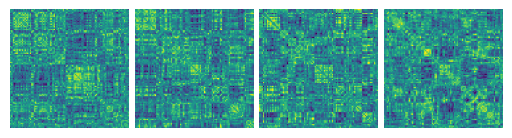

number 1 : prediction


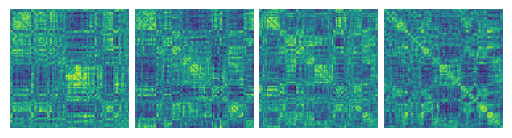

number 2 : real


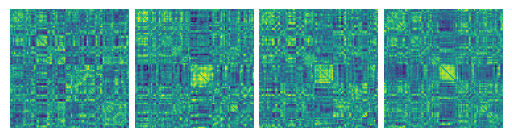

number 2 : prediction


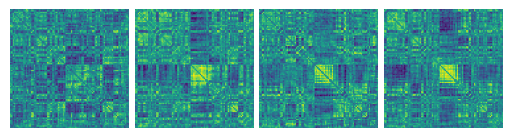

number 3 : real


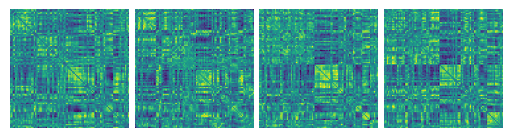

number 3 : prediction


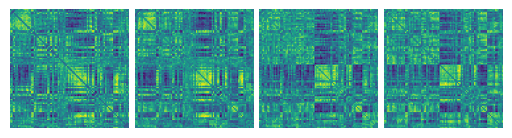

number 4 : real


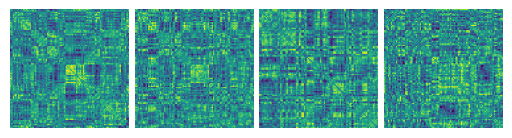

number 4 : prediction


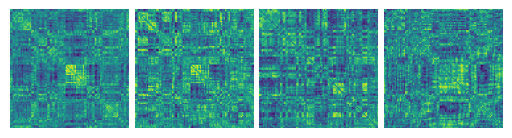

number 5 : real


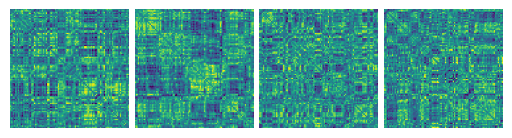

number 5 : prediction


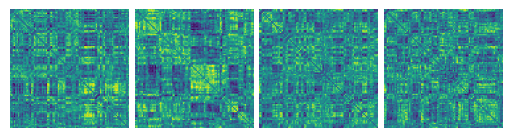

number 6 : real


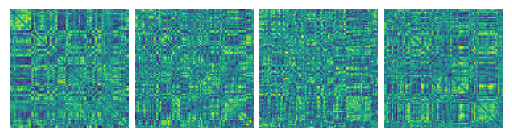

number 6 : prediction


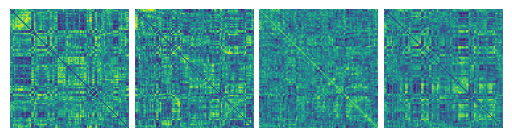

number 7 : real


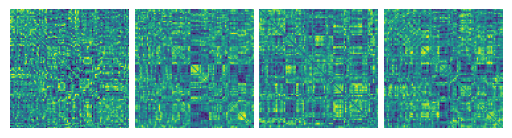

number 7 : prediction


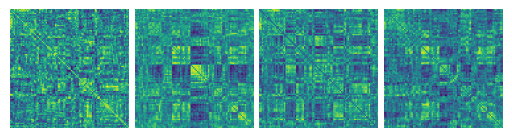

number 8 : real


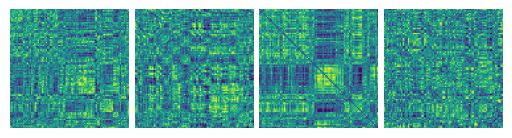

number 8 : prediction


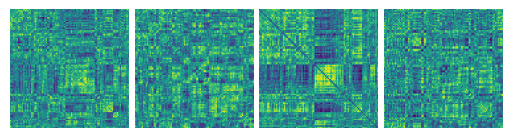

number 9 : real


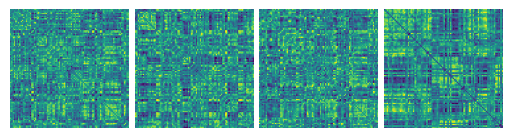

number 9 : prediction


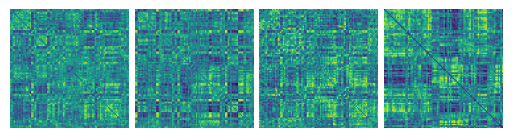

number 10 : real


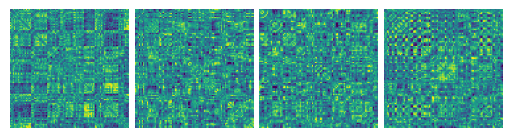

number 10 : prediction


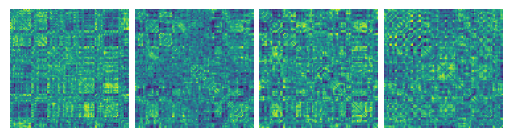

number 11 : real


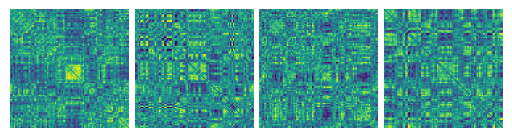

number 11 : prediction


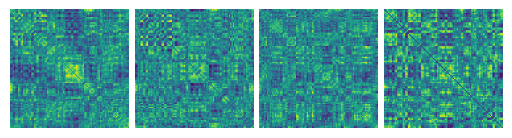

In [214]:
for batch, (images, _) in enumerate(test_dl):
  if batch > 10:
    break
  print('number', batch+1, ': real')
  show_image_grid(images, 128)
  vae.eval()
  with torch.no_grad():
    preds, _, _ = vae(flatten(images))
  print('number', batch+1, ': prediction')
  show_image_grid(preds.reshape(4, 90, 90), 128)

In [216]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
model = Autoencoder().to(device)


In [217]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n , Avg loss: {test_loss:>8f} \n")
    return test_loss

In [218]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [222]:
epochs = 50
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)

    train_loss = test(train_dl, model, loss_fn)
    test_loss = test(test_dl, model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.019012  [    8/  656]
loss: 0.020285  [   88/  656]
loss: 0.021013  [  168/  656]
loss: 0.020696  [  248/  656]
loss: 0.019386  [  328/  656]
loss: 0.018519  [  408/  656]
loss: 0.021064  [  488/  656]
loss: 0.019266  [  568/  656]
loss: 0.020345  [  648/  656]
Test Error: 
 , Avg loss: 0.020367 

Test Error: 
 , Avg loss: 0.020367 

Epoch 2
-------------------------------
loss: 0.020414  [    8/  656]
loss: 0.022956  [   88/  656]
loss: 0.018664  [  168/  656]
loss: 0.019711  [  248/  656]
loss: 0.020521  [  328/  656]
loss: 0.020995  [  408/  656]
loss: 0.021037  [  488/  656]
loss: 0.019897  [  568/  656]
loss: 0.019727  [  648/  656]
Test Error: 
 , Avg loss: 0.020199 

Test Error: 
 , Avg loss: 0.020199 

Epoch 3
-------------------------------
loss: 0.022518  [    8/  656]
loss: 0.022058  [   88/  656]
loss: 0.023056  [  168/  656]
loss: 0.020744  [  248/  656]
loss: 0.020621  [  328/  656]
loss: 0.019844  [  408/  656]
loss: 0.0189

In [223]:
b_img,b_mask = next(iter(test_dl))
with torch.no_grad():
    model.eval()
    logits = model(b_img.to(device))
# pr_masks = logits.sigmoid()
predictions = torch.argmax(logits, dim=1)  # 获取预测的类别标签图像
predictions.shape

torch.Size([4, 90, 90])

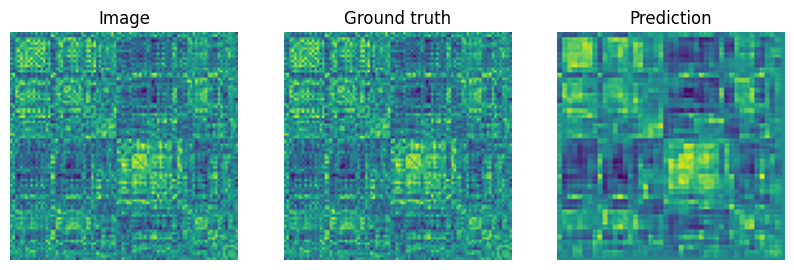

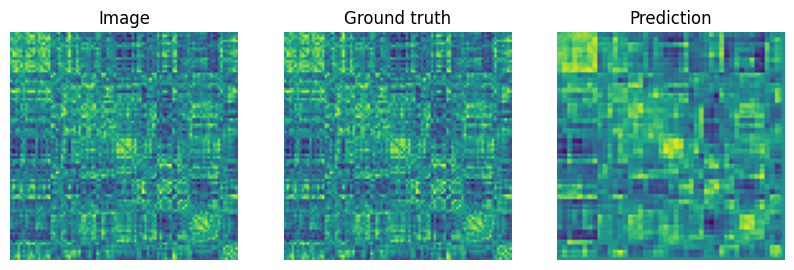

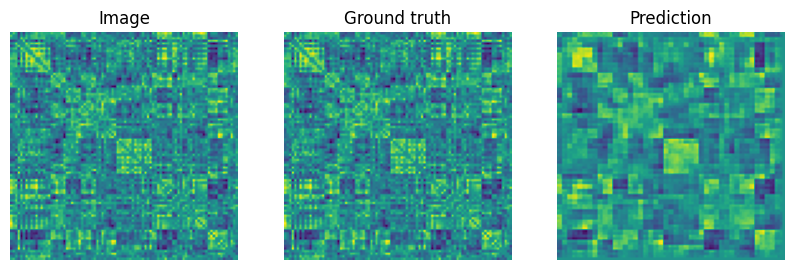

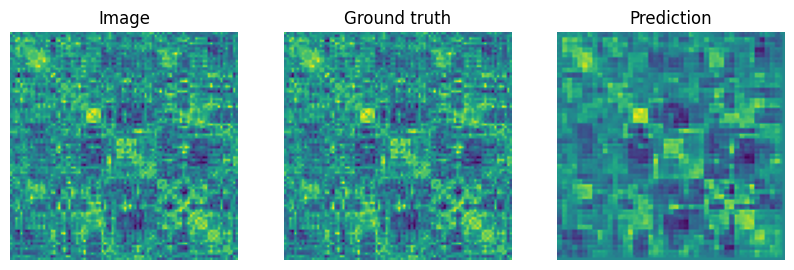

In [224]:


for image, gt_mask, pr_mask in zip(b_img,b_mask, logits):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(to_img(image).numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(to_img(gt_mask).numpy().transpose(1, 2, 0)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().transpose(1, 2, 0)) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()